Прогнозирование температуры звезды
Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
Закон смещения Вина.
Закон Стефана-Больцмана.
Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.
Характеристики
Относительная светимость L/Lo — светимость звезды относительно Солнца.
Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
Тип звезды.
Тип звезды	Номер, соответствующий типу
Коричневый карлик	0
Красный карлик	1
Белый карлик	2
Звёзды главной последовательности	3
Сверхгигант	4
Гипергигант	5
Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

In [1]:
#!pip install ydata_profiling
#!pip install optuna
#!pip install torch
#!pip install -U skorch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from math import sqrt

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna


RANDOM_SEED = 42


torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Загрузка данных

In [3]:
try:
    df = pd.read_csv('data/stars.csv')   
except:
    df = pd.read_csv('_stars.csv')

In [4]:
df

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


## Предобработка и анализ данных

In [5]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Для анализа и обучения представлены данные 240 объектов, целевой признак числовой, фичи  - это 3 числовых признака и 2 категориальных. Пропусков и дубликатов в данных нет. Численные признаки распределены ненормально. Обращает на себя внимание только распределение звёзд по типам равными долями (6 типов по 40 звёзд каждого). Цлевой признак коррелирует более, чем на 50% с показателями magnitude_abs, type и color.

In [6]:
df = df.drop('Unnamed: 0', axis=1).copy()

In [7]:
# создание словаря с новыми именами столбцов
new_column_names = {
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'magnitude_abs',
    'Star type': 'type',
    'Star color': 'color',
}
# переименование столбцов
df = df.rename(columns=new_column_names)

# вывод датасета с переименованными столбцами
display(df.head(2))

,temperature,luminosity,radius,magnitude_abs,type,color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red


In [8]:
print(f'Уникальные значения признака color в данных:\n{df["color"].unique()}')

Уникальные значения признака color в данных:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


In [9]:
# перевод записей в нижний регистр
df['color'] = df['color'].str.lower()
# стандартизация разделителей
df['color'] = df['color'].str.replace('-', ' ')
# удаление лишних пробельных символов
df['color'] = df['color'].str.strip()

In [10]:
df['color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

In [11]:
# создание словаря
replace_color = {
    'yellowish white': 'yellow',
    'yellow white': 'yellow',
    'yellowish': 'yellow',
    'pale yellow orange': 'yellow',
    'whitish': 'white',
    'white yellow': 'white',
    'orange red': 'orange',
}
# снижаем кол-во категорий в колонке
df['color'] = df['color'].replace(replace_color).copy()

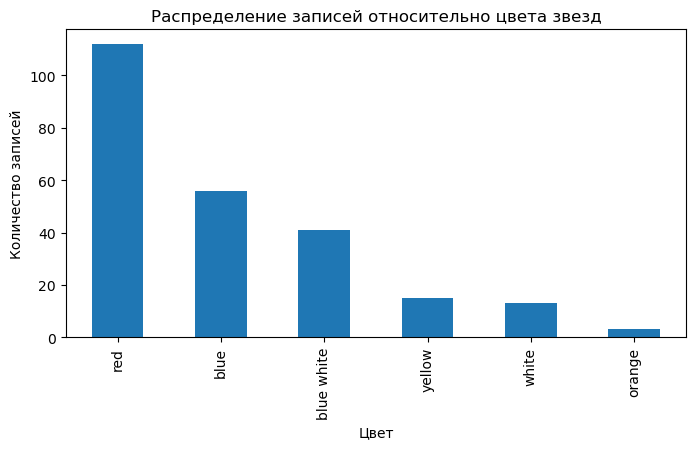

In [12]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()


In [13]:
X = df.drop('temperature', axis=1)
y = df['temperature'] # целевой признак

In [14]:
X

,luminosity,radius,magnitude_abs,type,color
0,0.002400,0.1700,16.12,0,red
1,0.000500,0.1542,16.60,0,red
2,0.000300,0.1020,18.70,0,red
3,0.000200,0.1600,16.65,0,red
4,0.000138,0.1030,20.06,0,red
...,...,...,...,...,...
235,374830.000000,1356.0000,-9.93,5,blue
236,834042.000000,1194.0000,-10.63,5,blue
237,537493.000000,1423.0000,-10.73,5,white
238,404940.000000,1112.0000,-11.23,5,white


In [15]:
# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [16]:
# проверка размерности выборок
for x in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'Размерность {x}: {globals()[x].shape} - {len(globals()[x])/len(df):.0%}')

Размерность X_train: (192, 5) - 80%
Размерность X_test: (48, 5) - 20%
Размерность y_train: (192,) - 80%
Размерность y_test: (48,) - 20%


In [17]:
X_train

,luminosity,radius,magnitude_abs,type,color
139,0.001300,0.2560,14.330,1,red
60,0.005600,0.0570,16.230,0,red
204,0.001340,0.0124,11.220,2,blue
186,0.000461,0.1190,17.450,0,red
207,0.001320,0.0104,10.180,2,blue
...,...,...,...,...,...
106,363000.000000,63.0000,-5.830,4,blue
14,0.000600,0.1400,11.782,1,red
92,0.085000,0.7950,6.228,3,yellow
179,248490.000000,1134.5000,-8.240,5,blue white


In [18]:
numeric_columns = ['luminosity', 'radius', 'magnitude_abs']
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
#нормализуем численные значения признаков

In [19]:
X_train

,luminosity,radius,magnitude_abs,type,color
139,-0.581290,-0.433580,0.922677,1,red
60,-0.581290,-0.433984,1.105516,0,red
204,-0.581290,-0.434074,0.623397,2,blue
186,-0.581290,-0.433858,1.222919,0,red
207,-0.581290,-0.434078,0.523316,2,blue
...,...,...,...,...,...
106,1.578005,-0.306339,-1.017348,4,blue
14,-0.581290,-0.433815,0.677479,1,red
92,-0.581289,-0.432487,0.143010,3,yellow
179,0.896846,1.866600,-1.249266,5,blue white


In [20]:
X_train = pd.get_dummies (X_train, columns=['type', 'color'], drop_first= True )
X_test = pd.get_dummies (X_test, columns=['type', 'color'], drop_first= True )
#преобразуем категориальные признаки

In [21]:
X_train

,luminosity,radius,magnitude_abs,type_1,type_2,type_3,type_4,type_5,color_blue white,color_orange,color_red,color_white,color_yellow
139,-0.581290,-0.433580,0.922677,1,0,0,0,0,0,0,1,0,0
60,-0.581290,-0.433984,1.105516,0,0,0,0,0,0,0,1,0,0
204,-0.581290,-0.434074,0.623397,0,1,0,0,0,0,0,0,0,0
186,-0.581290,-0.433858,1.222919,0,0,0,0,0,0,0,1,0,0
207,-0.581290,-0.434078,0.523316,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1.578005,-0.306339,-1.017348,0,0,0,1,0,0,0,0,0,0
14,-0.581290,-0.433815,0.677479,1,0,0,0,0,0,0,1,0,0
92,-0.581289,-0.432487,0.143010,0,0,1,0,0,0,0,0,0,1
179,0.896846,1.866600,-1.249266,0,0,0,0,1,1,0,0,0,0


In [22]:
X_train_tensor = torch.FloatTensor(np.array(X_train))
X_test_tensor = torch.FloatTensor(np.array(X_test))
y_train_tensor = torch.FloatTensor(np.array(y_train))
y_test_tensor = torch.FloatTensor(np.array(y_test))

# Проверка размерности тензоров
for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape}')

Размерность X_train_tensor: torch.Size([192, 13])
Размерность X_test_tensor: torch.Size([48, 13])
Размерность y_train_tensor: torch.Size([192])
Размерность y_test_tensor: torch.Size([48])


## Промежуточный вывод 1

Для анализа и обучения представлены данные 240 объектов, целевой признак числовой, фичи  - это 3 числовых признака и 2 категориальных. Пропусков и дубликатов в данных нет. Численные признаки распределены ненормально. Обращает на себя внимание только распределение звёзд по типам равными долями (6 типов по 40 звёзд каждого). Цлевой признак коррелирует более, чем на 50% с показателями magnitude_abs, type и color. В ходе предварительной обработки выполнена нормализация числовых и преобразование категориальных признаков.

## Построение базовой нейронной сети

In [23]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

In [24]:
# класс для создания пакетов
class Batch(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]
    data = self.data[idx]
    sample = {'data': data, 'temperature': label}
    return sample

In [25]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_test_tensor, y_test_tensor)

In [26]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]  
hidden_size_1 = 39  
hidden_size_2 = 39  
hidden_size_3 = 26  
hidden_size_4 = 13  
output_size = 1 
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.ReLU()
activation_3 = nn.ReLU()
activation_4 = nn.ReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.1
drop_3 = 0.1
drop_4 = 0.1

learning_rate = 0.005  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 32  # размер пакета

In [27]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [28]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться
        :param min_delta: минимальная разница функций потерь для активации param patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss 
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

In [29]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    
    result = {'rmse_train': [],
             'rmse_test': [],
             'best_epoch': None,
             'stopping_epoch': None,
             'best_model': None}
    
    early_stopping = CustomEarlyStopping(patience, min_delta)
    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['temperature']
            
            optimizer.zero_grad()
            
            predictions = model.forward(data).flatten()
            loss_value = loss(predictions, label_train)
            total_loss += loss_value.item()
            
            loss_value.backward()
            optimizer.step()
            
        rmse_tr = sqrt(total_loss/len(train_dataloader))
        result['rmse_train'].append(rmse_tr)
        
        # тестирование
        model.eval()
        total_loss = 0.0
        with torch.no_grad(): # отключаем вычисление градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['temperature']
                
                predictions = model.forward(data).flatten()
                loss_value = loss(predictions, label_test)
                total_loss += loss_value
            rmse_ts = sqrt(total_loss/len(test_dataloader))
            result['rmse_test'].append(rmse_ts)
            
        if epoch % 10 == 0 or epoch == n_epochs - 1:    
             print(f'Epoch: {epoch} RMSE_train: {round(rmse_tr)} RMSE_test: {round(rmse_ts)}')
        
        early_stopping(rmse_ts)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch-patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch-patience} RMSE_train: {round(result['rmse_train'][-patience])} RMSE_test: {round(result['rmse_test'][-patience])}")
            break
        if epoch == n_epochs-1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch} RMSE_train: {round(result['rmse_train'][-1])} RMSE_test: {round(result['rmse_test'][-1])}")        
    return result

In [30]:
# обучение и сохранение результатов
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 13899 RMSE_test: 13972
Epoch: 10 RMSE_train: 12467 RMSE_test: 11857
Epoch: 20 RMSE_train: 7782 RMSE_test: 7402
Epoch: 30 RMSE_train: 7018 RMSE_test: 7047
Epoch: 40 RMSE_train: 6364 RMSE_test: 6737
Epoch: 50 RMSE_train: 6425 RMSE_test: 6632
Epoch: 60 RMSE_train: 5105 RMSE_test: 6251
Epoch: 70 RMSE_train: 5291 RMSE_test: 5924
Epoch: 80 RMSE_train: 5263 RMSE_test: 5566
Epoch: 90 RMSE_train: 4640 RMSE_test: 5341
Epoch: 100 RMSE_train: 4687 RMSE_test: 5159
Epoch: 110 RMSE_train: 4676 RMSE_test: 5161
Epoch: 120 RMSE_train: 4572 RMSE_test: 5071
Epoch: 130 RMSE_train: 4609 RMSE_test: 4987
Epoch: 140 RMSE_train: 4488 RMSE_test: 5105
Epoch: 150 RMSE_train: 4666 RMSE_test: 5048
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 132 RMSE_train: 4537 RMSE_test: 5005


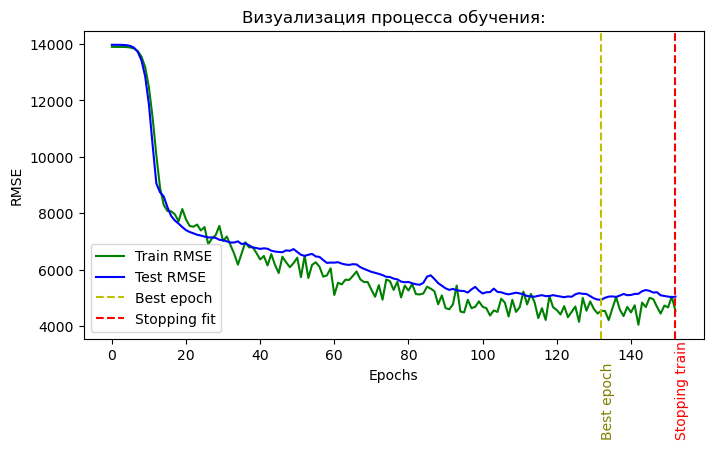

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

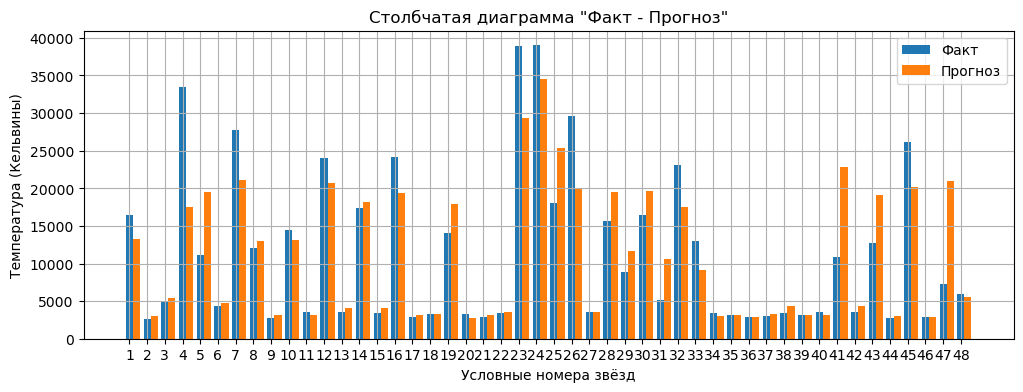

In [32]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = result['best_model'].forward(X_test_tensor).detach().numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(12, 4))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

## Промежуточный вывод 2

Для обучения и предсказания целевого признака была составлена полносвязная нейронная сеть с 4 скрытыми слоями. На тестовой выборке отмечались значительные расхождения значений фактического и предсказанного целевого признака у тех объектов, у которых фактическое значение целевого признака резко отличалось от среднего. Таким образом, модель в своих предсказаниях усредняла целевой показатель. Вероятнее всего, это связано с недостаточным количеством объектов для обучения модели.

## Улучшение нейронной сети

In [33]:
# фукция для расчета RMSE
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

In [34]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    
    activation_1 = nn.ReLU()
    activation_2 = nn.ReLU()
    activation_3 = nn.ReLU()
    activation_4 = nn.ReLU()

    

    # количество нейронов
    input_size = X_train_tensor.shape[1] 
    output_size = 1

    hidden_size_1 = 39
    hidden_size_2 = 39
    hidden_size_3 = 26
    hidden_size_4 = 13



    # скорость обучения
    lr = 0.005
    
    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 13, 120,  step=10)
    
    # модель
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 60,  step=5)

    # параметры подбора параметров модели
    skorch_regressor = NeuralNetRegressor(module=model_base,
                                      device='cpu',
                                      verbose=0,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam,
                                      max_epochs=2500,
                                      lr=lr,
                                      train_split=ValidSplit(cv=4),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience))
            ]
                                     )



    rmse = cross_val_score(skorch_regressor, X_train_tensor.numpy().astype('float32'),
                            y_train_tensor.numpy().astype('float32').reshape(-1,1),
                            n_jobs=-1,
                            cv=4,
                           scoring=rmse_scorer)
    rmse = abs(rmse.mean())
    return rmse

In [35]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

[I 2023-08-12 22:05:00,053] A new study created in memory with name: no-name-3395be34-89e0-403e-a7af-a1c8feb07f47
C:\Users\mamon\anaconda3\lib\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [13, 120] and step=10, but the range is not divisible by `step`. It will be replaced by [13, 113].
  warnings.warn(
[I 2023-08-12 22:05:05,706] Trial 0 finished with value: 5096.773023370031 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.2, 'module__drop_4': 0.5, 'batch_size': 113, 'patience': 50}. Best is trial 0 with value: 5096.773023370031.
[I 2023-08-12 22:05:11,037] Trial 1 finished with value: 5028.142119309603 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.5, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'batch_size': 33, 'patience': 50}. Best is trial 1 with value: 5028.142119309603.
[I 2023-08-12 22:05:13,309] Trial 2 finished with value: 7001.264920590882 and paramete

[I 2023-08-12 22:06:22,125] Trial 29 finished with value: 5105.395619568191 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.2, 'module__drop_4': 0.0, 'batch_size': 23, 'patience': 40}. Best is trial 10 with value: 4846.987549422006.
[I 2023-08-12 22:06:24,960] Trial 30 finished with value: 5004.9335897658875 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'batch_size': 83, 'patience': 50}. Best is trial 10 with value: 4846.987549422006.
[I 2023-08-12 22:06:27,203] Trial 31 finished with value: 4928.799996147545 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.1, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'batch_size': 43, 'patience': 45}. Best is trial 10 with value: 4846.987549422006.
[I 2023-08-12 22:06:30,147] Trial 32 finished with value: 4848.223741935469 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.1, 'module_

[I 2023-08-12 22:07:58,412] Trial 59 finished with value: 4974.959322652995 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.0, 'module__drop_3': 0.2, 'module__drop_4': 0.1, 'batch_size': 43, 'patience': 60}. Best is trial 42 with value: 4774.778094804694.
[I 2023-08-12 22:08:01,010] Trial 60 finished with value: 4785.820832342631 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.2, 'module__drop_4': 0.4, 'batch_size': 23, 'patience': 55}. Best is trial 42 with value: 4774.778094804694.
[I 2023-08-12 22:08:03,261] Trial 61 finished with value: 4808.177107009323 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.2, 'module__drop_4': 0.30000000000000004, 'batch_size': 23, 'patience': 55}. Best is trial 42 with value: 4774.778094804694.
[I 2023-08-12 22:08:07,049] Trial 62 finished with value: 4748.275296568455 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.1, 'module__drop_3': 0.2, 'module__drop_4': 

[I 2023-08-12 22:09:55,589] Trial 90 finished with value: 4836.392084048097 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.0, 'module__drop_3': 0.2, 'module__drop_4': 0.5, 'batch_size': 13, 'patience': 60}. Best is trial 62 with value: 4748.275296568455.
[I 2023-08-12 22:09:59,256] Trial 91 finished with value: 4801.737018725481 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.0, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 62 with value: 4748.275296568455.
[I 2023-08-12 22:10:02,131] Trial 92 finished with value: 4908.9160929997115 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.0, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 55}. Best is trial 62 with value: 4748.275296568455.
[I 2023-08-12 22:10:06,201] Trial 93 finished with value: 4861.9823123923525 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.0, 'module__drop_3': 0.1, 'module__drop_4': 0.4, 'batch_si

[I 2023-08-12 22:11:42,453] Trial 121 finished with value: 4905.632152371754 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:11:45,191] Trial 122 finished with value: 4868.32956911143 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:11:48,620] Trial 123 finished with value: 4941.29125019779 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:11:51,485] Trial 124 finished with value: 4963.740310878659 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.4, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'batch

[I 2023-08-12 22:13:44,080] Trial 152 finished with value: 5008.737514802145 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 55}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:13:48,321] Trial 153 finished with value: 4911.622605063148 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 60}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:13:52,186] Trial 154 finished with value: 4954.573594179036 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 50}. Best is trial 116 with value: 4736.880361397167.
[I 2023-08-12 22:13:55,255] Trial 155 finished with value: 4901.803963244845 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'bat

[I 2023-08-12 22:15:31,132] Trial 182 finished with value: 4963.342733373511 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.0, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:15:35,607] Trial 183 finished with value: 4718.850288872019 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 60}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:15:40,290] Trial 184 finished with value: 4886.678599090807 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 45}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:15:43,510] Trial 185 finished with value: 5338.251605630936 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'm

[I 2023-08-12 22:17:30,336] Trial 211 finished with value: 4916.648176716912 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:17:33,088] Trial 212 finished with value: 4809.96486531549 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 50}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:17:37,446] Trial 213 finished with value: 4917.938359534138 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.0, 'batch_size': 13, 'patience': 50}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:17:41,726] Trial 214 finished with value: 4919.401838045273 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.300000

[I 2023-08-12 22:19:26,264] Trial 240 finished with value: 4846.036400625292 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:19:28,397] Trial 241 finished with value: 4950.645005843708 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 63, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:19:31,627] Trial 242 finished with value: 4953.505176686819 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:19:35,839] Trial 243 finished with value: 4910.961658769777 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000

[I 2023-08-12 22:21:33,145] Trial 269 finished with value: 4997.811662973076 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:21:37,064] Trial 270 finished with value: 4894.42575320634 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 13, 'patience': 60}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:21:40,617] Trial 271 finished with value: 4773.44652051497 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.2, 'batch_size': 23, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:21:43,340] Trial 272 finished with value: 4888.589749685625 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.3000000

[I 2023-08-12 22:23:10,798] Trial 298 finished with value: 5043.227793865046 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.
[I 2023-08-12 22:23:15,077] Trial 299 finished with value: 4732.627780383411 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.2, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'batch_size': 13, 'patience': 55}. Best is trial 168 with value: 4641.522170164162.


Wall time: 18min 15s


In [36]:
print(f'Лучшее значение RMSE: {round(study.best_trial.values[0])}')

Лучшее значение RMSE: 4642


In [37]:
best_params = study.best_trial.params
display('Оптимальные параметры:', best_params)

'Оптимальные параметры:'

{'module__drop_1': 0.30000000000000004,
 'module__drop_2': 0.5,
 'module__drop_3': 0.1,
 'module__drop_4': 0.1,
 'batch_size': 13,
 'patience': 55}

In [38]:
# инициализация оптимальных параметров


input_size = X_train.shape[-1]
output_size = 1

hidden_size_1 = 39
hidden_size_2 = 39
hidden_size_3 = 26
hidden_size_4 = 13

drop_1 = round(best_params['module__drop_1'], 1)
drop_2 = round(best_params['module__drop_2'], 1)
drop_3 = round(best_params['module__drop_3'], 1)
drop_4 = round(best_params['module__drop_4'], 1)

activation_1 = nn.ReLU()
activation_2 = nn.ReLU()
activation_3 = nn.ReLU()
activation_4 = nn.ReLU()


learning_rate = 0.005

batch_size = best_params['batch_size']

patience = best_params['patience']

n_epochs = 1000

In [39]:
# экземпляр нейронной сети
model_test = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                      drop_1, drop_2, drop_3, drop_4,
                      activation_1, activation_2, activation_3, activation_4)

# функция потерь
loss = nn.MSELoss()

# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

In [40]:
# обучение и сохранение результатов
result_test = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=patience,
               min_delta=0)

Epoch: 0 RMSE_train: 4923 RMSE_test: 5189
Epoch: 10 RMSE_train: 4975 RMSE_test: 5275
Epoch: 20 RMSE_train: 4393 RMSE_test: 5424
Epoch: 30 RMSE_train: 4727 RMSE_test: 5362
Epoch: 40 RMSE_train: 4772 RMSE_test: 5399
Epoch: 50 RMSE_train: 4157 RMSE_test: 5383
INFO: Ранняя остановка. Счетчик: 55/55
Best epoch: 1 RMSE_train: 4718 RMSE_test: 5410


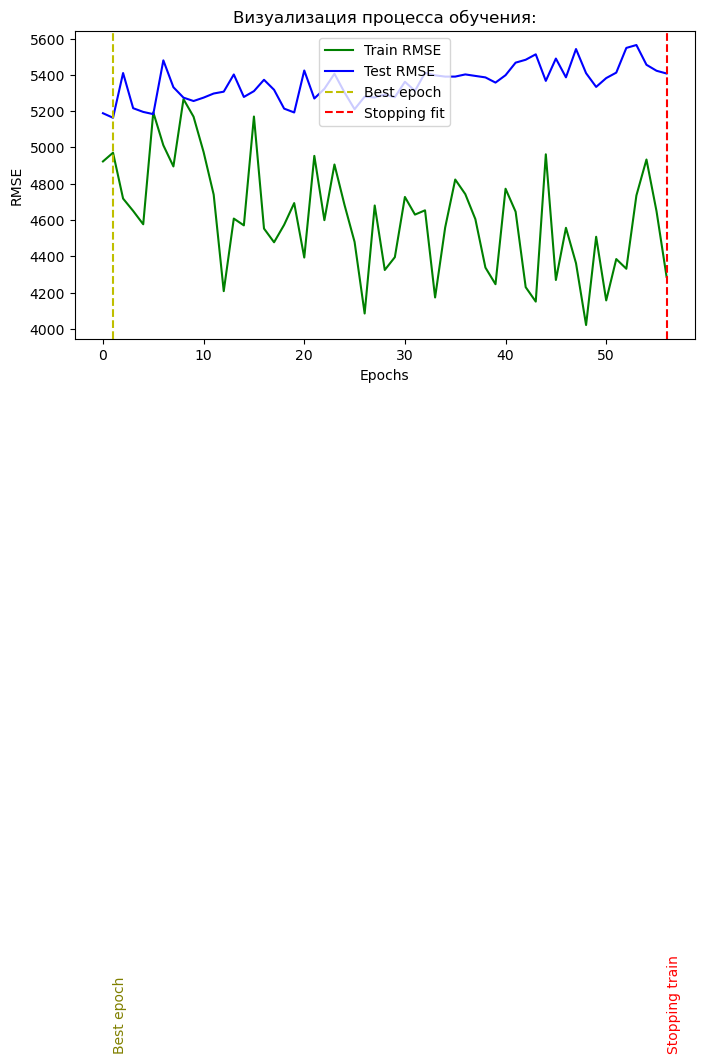

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(result_test['rmse_train'], color='green', label='Train RMSE')
plt.plot(result_test['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result_test['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result_test['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result_test['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result_test['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper center')
plt.show()

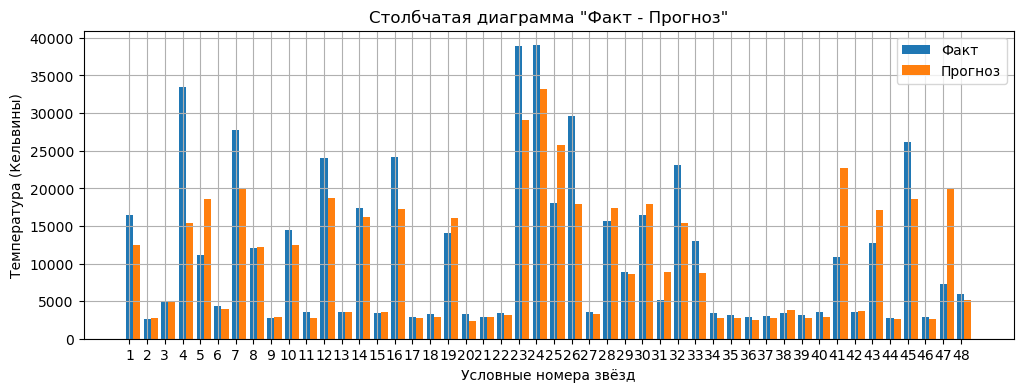

In [42]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = result_test['best_model'].forward(X_test_tensor).detach().numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(12, 4))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

## Промежуточный вывод 3

Для оптимизации параметров модели применялся фреймворк для для автоматизированного поиска оптимальных гиперпараметров Optuna. Подбирались гиперпараметры (размер батча, параметры DropOut), однако это только ухудшило предсказательную силу модели. Тенденция к усреднению предсказанных результатов сохранилась.

## Выводы

В рамках данного проекта был проведен анализ и предобработка данных, направленных на предсказание температуры звезд. Для этой задачи были разработаны и проверены на данных две нейронные сети.

Обучив Baseline-модель, были получены следующие результаты: RMSE_train: 4537, RMSE_test: 5005. Модель демонстрировала способность предсказывать температуру звезд, но на графике "Факт - Прогноз" была заметна тенденция предсказывать более усредненные значения для наиболее горячих звезд.

Для улучшения качества предсказания, мы приступили к разработке второй модели и использовали библиотеку Optuna для автоматического подбора оптимальных параметров. Были оптимизированы следующие параметры модели:

Размер пакета обучения (batch size): Оптимальный размер пакета составил 13.

Dropout: Метод Dropout позволяет уменьшить взаимозависимость между нейронами, что делает модель более устойчивой к шуму и способной лучше обобщать на новые данные. Оптимальные значения Dropout были установлены как 0.3, 0.5, 0.1 и 0.1 для каждого слоя соответственно.

После проведения оптимизации параметров, вторая модель показала следующие результаты: RMSE_train: 4718, RMSE_test: 5410. 

Дальнейшие улучшения могут быть достигнуты путем сбора дополнительных данных, оптимизации других параметров обучения, исследования различных архитектур сетей и использования ансамблей моделей для улучшения предсказательной способности.

Примечание:
Очень странный эффект подбора параметров, пытался подбирать различные комбинации кол-ва нейронов, различные функции активации и learning_rate, однако значимо результат не улучшался. 